# **Vehicle Detection and Tracking** 

In this project, I combine computer vision techniques and machine learning to identify vehicles in a video stream.

This notebook will serve as my documentation, sample images, and finished project. 

In [19]:
import matplotlib.image as mpimg
import numpy as np
import cv2
from skimage.feature import hog
import matplotlib.pyplot as plt
import glob
import time
from sklearn.svm import LinearSVC
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
import random

from tqdm import tqdm 

## Set Test Image for Feature Extraction

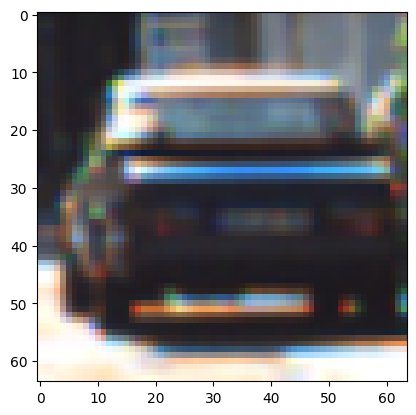

In [10]:
test_img_loc = '../data/vehicles/1.png'
feature_image = cv2.imread(test_img_loc)
feature_image = cv2.cvtColor(feature_image, cv2.COLOR_BGR2RGB)
plt.imshow(feature_image)
plt.show()

## Set Hyperparameters

In [27]:
color_space = 'YCrCb' # Can be RGB, HSV, LUV, HLS, YUV, YCrCb
orient = 9  # HOG orientations
pix_per_cell = 8 # HOG pixels per cell
cell_per_block = 2 # HOG cells per block
hog_channel = 'ALL' # Can be 0, 1, 2, or "ALL"
spatial_size = (32, 32) # Spatial binning dimensions
hist_bins = 32    # Number of histogram bins
spatial_feat = True # Spatial features on or off
hist_feat = True # Histogram features on or off
hog_feat = True # HOG features on or off
y_start_stop = [150, 650] # Min and max in y to search in slide_window()

## Histogram of Oriented Gradients (HOG)

#### 1. Explain how you extracted HOG features from the training images.

To tune my usage of the skimage hog feature, I began with a basic car image from the training set. I applied the hog function using the hyperparemeter values from the lesson (9 orientations, 8 pixels per cell, and 2 cells per block). Then I displayed that image in my notebook. This confirmed that the function was correctly extracting gradient features.

Next, I experimented with different values for the hyperparameters to see if I could more accurately detect the unique shape of a vehicle. I evaluated the impact of my tweaks by looking at the image produced by the hog function and the impact that the tweak had on my SVL classifier's overall accuracy. 

#### 2. Explain how you settled on your final choice of HOG parameters.

Ultimately I found that using YCrCB color space, 9 orientations, 8 pixels per cell, and 2 cells per block were very effective. One change that I made was using all of the hog channels and increase of my spatial and color histogram bins. These modifications made my overall pipeline significantly slower, but improved my classification accuracy on the validation set from .96 to .99. It also improved the accuracy on my manually labeled set of windows (pulled from the project video) from .4 to .55. 

#### 3. Describe how you trained a classifier using your selected HOG features (and color features if you used them).

I trained a linear SVM with a combination of HOG, spatial, and color features.

The first step was loading all of the training images of both cars and noncars. It was very important to trim each set to the size of the smaller set to ensure the classifier received an equal of car and noncar images. 

Next I extracted the HOG features from each image using the hyperparameters I had tuned on sample images. I also pulled out the spatial features of a downgraded (32, 32) version of each training image in RGB color space. This helps our classifier get a sense for where the different colors are within the image. Another feature that I feed to my classifier is a histogram that captures the general distribution of colors within the image, irrespective of the actual location of the colors within the image. This is very useful as many cars have similar color distributions while still having significant differences in shape. 

The results of each of these techniques by themselves can be seen next to the code that produced it in the images below.

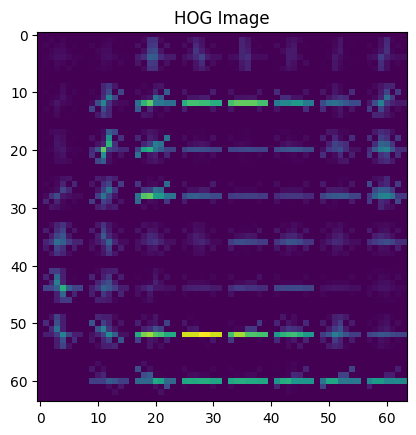

In [13]:
# Define a function to return HOG features and visualization
def get_hog_features(img, orient, pix_per_cell, cell_per_block, 
                        vis=False, feature_vec=True):
    # Call with two outputs if vis==True
    if vis == True:
        features, hog_image = hog(img, orientations=orient, 
                                  pixels_per_cell=(pix_per_cell, pix_per_cell),
                                  cells_per_block=(cell_per_block, cell_per_block), 
                                  transform_sqrt=True, 
                                  visualize=vis, feature_vector=feature_vec)
        return features, hog_image
    # Otherwise call with one output
    else:      
        features = hog(img, orientations=orient, 
                       pixels_per_cell=(pix_per_cell, pix_per_cell),
                       cells_per_block=(cell_per_block, cell_per_block), 
                       transform_sqrt=True, 
                       visualize=vis, feature_vector=feature_vec)
        return features

feature_image = cv2.imread(test_img_loc)
feature_image = cv2.cvtColor(feature_image, cv2.COLOR_BGR2RGB)
hog_features, hog_image = get_hog_features(feature_image[:,:,0], orient, 
                        pix_per_cell, cell_per_block, vis=True, feature_vec=True)
plt.imshow(hog_image)
plt.title('HOG Image')
plt.show()

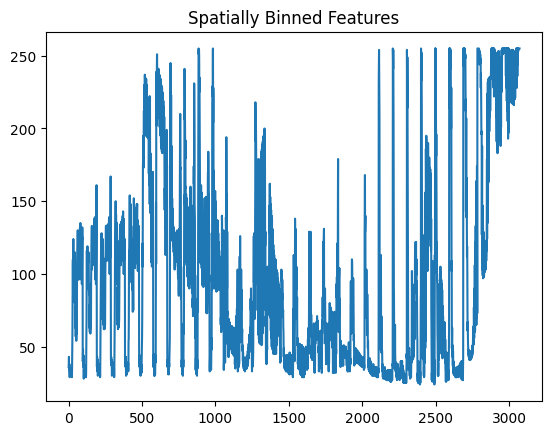

In [14]:
# Define a function to compute binned color features  
def bin_spatial(img, size=(32, 32)):
    # Use cv2.resize().ravel() to create the feature vector
    features = cv2.resize(img, size).ravel() 
    # Return the feature vector
    return features

# Plot features
feature_image = cv2.imread(test_img_loc)
feature_image = cv2.cvtColor(feature_image, cv2.COLOR_BGR2RGB)
feature_vec = bin_spatial(feature_image, size=spatial_size)
plt.plot(feature_vec)
plt.title('Spatially Binned Features')
plt.show()

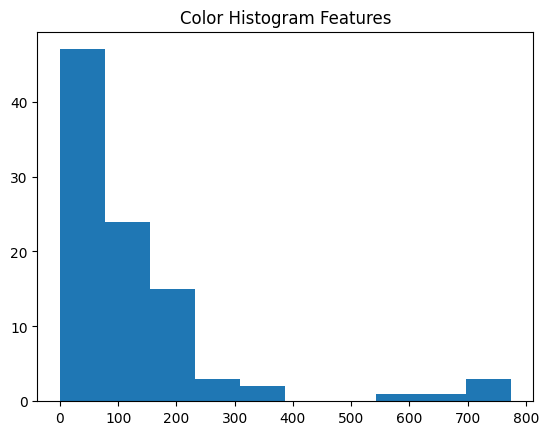

In [15]:
# Define a function to compute color histogram features 
# NEED TO CHANGE bins_range if reading .png files with mpimg!
def color_hist(img, nbins=32, bins_range=(0, 256)):
    # Compute the histogram of the color channels separately
    channel1_hist = np.histogram(img[:,:,0], bins=nbins, range=bins_range)
    channel2_hist = np.histogram(img[:,:,1], bins=nbins, range=bins_range)
    channel3_hist = np.histogram(img[:,:,2], bins=nbins, range=bins_range)
    # Concatenate the histograms into a single feature vector
    hist_features = np.concatenate((channel1_hist[0], channel2_hist[0], channel3_hist[0]))
    # Return the individual histograms, bin_centers and feature vector
    return hist_features

feature_image = cv2.imread(test_img_loc)
feature_image = cv2.cvtColor(feature_image, cv2.COLOR_BGR2RGB)
hist_features = color_hist(feature_image, nbins=hist_bins)
plt.hist(hist_features)
plt.title('Color Histogram Features')
plt.show()

## Extract Features

In [20]:
# Define a function to extract features from a single image window
def single_img_features(img, color_space='RGB', spatial_size=(32, 32),
                        hist_bins=32, orient=9, 
                        pix_per_cell=8, cell_per_block=2, hog_channel=0,
                        spatial_feat=True, hist_feat=True, hog_feat=True, hog_features=None):    
    #1) Define an empty list to receive features
    img_features = []
    #2) Apply color conversion if other than 'RGB'
    if color_space != 'RGB':
        if color_space == 'HSV':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2HSV)
        elif color_space == 'LUV':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2LUV)
        elif color_space == 'HLS':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
        elif color_space == 'YUV':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2YUV)
        elif color_space == 'YCrCb':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2YCrCb)
    else: feature_image = np.copy(img)      
    #3) Compute spatial features if flag is set
    if spatial_feat == True:
        spatial_features = bin_spatial(feature_image, size=spatial_size)
        #4) Append features to list
        img_features.append(spatial_features)
    #5) Compute histogram features if flag is set
    if hist_feat == True:
        hist_features = color_hist(feature_image, nbins=hist_bins)
        #6) Append features to list
        img_features.append(hist_features)
    #7) Compute HOG features if flag is set
    if hog_feat == True:
        if True: #hog_features is None:
            if hog_channel == 'ALL':
                hog_features = []
                for channel in range(feature_image.shape[2]):
                    hog_features.extend(get_hog_features(feature_image[:,:,channel], 
                                        orient, pix_per_cell, cell_per_block, 
                                        vis=False, feature_vec=True))      
            else:
                hog_features = get_hog_features(feature_image[:,:,hog_channel], orient, 
                            pix_per_cell, cell_per_block, vis=False, feature_vec=True)
        #8) Append features to list
        img_features.append(hog_features)

    #9) Return concatenated array of features
    return np.concatenate(img_features)

# Define a function to extract features from a list of images
# Have this function call bin_spatial() and color_hist()
def extract_features(imgs, color_space='RGB', spatial_size=(32, 32),
                        hist_bins=32, orient=9, 
                        pix_per_cell=8, cell_per_block=2, hog_channel=0,
                        spatial_feat=True, hist_feat=True, hog_feat=True):
    # Create a list to append feature vectors to
    features = []
    # Iterate through the list of images
    for file in tqdm(imgs):
        img = cv2.imread(file)
        file_features = single_img_features(img, color_space, spatial_size,
            hist_bins, orient, pix_per_cell, cell_per_block, hog_channel,
            spatial_feat, hist_feat, hog_feat)
        features.append(file_features)
    # Return list of feature vectors
    return features

## Train Car Classifier

In [21]:
def prepare_images_for_processing(car_img_folders, noncar_img_folders, image_type):
    cars = []
    for folder in car_img_folders:
        cars += glob.glob(folder +'/*.' + image_type)
        
    notcars = []
    for folder in noncar_img_folders:
        notcars += glob.glob(folder +'/*.' + image_type)

    print("Cars len: ", len(cars))
    print("Notcars len: ", len(notcars))

    # Keep distribution even
    train_size = 8500
    cars = cars[:train_size]
    notcars = notcars[:train_size]
    
    car_features = extract_features(cars, color_space=color_space, 
        spatial_size=spatial_size, hist_bins=hist_bins, 
        orient=orient, pix_per_cell=pix_per_cell, 
        cell_per_block=cell_per_block, 
        hog_channel=hog_channel, spatial_feat=spatial_feat, 
        hist_feat=hist_feat, hog_feat=hog_feat)
    notcar_features = extract_features(notcars, color_space=color_space, 
        spatial_size=spatial_size, hist_bins=hist_bins, 
        orient=orient, pix_per_cell=pix_per_cell, 
        cell_per_block=cell_per_block, 
        hog_channel=hog_channel, spatial_feat=spatial_feat, 
        hist_feat=hist_feat, hog_feat=hog_feat)

    X = np.vstack((car_features, notcar_features)).astype(np.float64)                        
    # Fit a per-column scaler
    X_scaler = StandardScaler().fit(X)
    # Apply the scaler to X
    scaled_X = X_scaler.transform(X)

    # Define the labels vector
    y = np.hstack((np.ones(len(car_features)), np.zeros(len(notcar_features))))
    
    return scaled_X, y, X_scaler

In [22]:
car_folders = ['../data/vehicles']
notcar_folders = ['../data/non-vehicles']
scaled_X, y, X_scaler = prepare_images_for_processing(car_folders, notcar_folders, "png")
# Split up data into randomized training and test sets
rand_state = np.random.randint(0, 100)
X_train, X_test, y_train, y_test = train_test_split(
    scaled_X, y, test_size=0.2, random_state=rand_state)

print('Using:',orient,'orientations',pix_per_cell,
    'pixels per cell and', cell_per_block,'cells per block')
print('Feature vector length:', len(X_train[0]))
# Use a linear SVC 
svc = LinearSVC()
# Check the training time for the SVC
t=time.time()
svc.fit(X_train, y_train)
t2 = time.time()
print(round(t2-t, 2), 'Seconds to train SVC...')
# Check the score of the SVC
print('Test Accuracy of SVC = ', round(svc.score(X_test, y_test), 4))
# Check the prediction time for a single sample
t=time.time()

Cars len:  8374
Notcars len:  8968


100%|██████████| 8500/8500 [02:45<00:00, 51.22it/s]


Using: 9 orientations 8 pixels per cell and 2 cells per block
Feature vector length: 8460


c:\Users\alexa\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\svm\_classes.py:32: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(


4.11 Seconds to train SVC...
Test Accuracy of SVC =  0.9944


In [23]:
car_folders_video = ['../data/train']
notcars_folders_video = ['noncar_windows']
scaled_X_video, y_video, X_scaler_video = prepare_images_for_processing(car_folders_video, notcars_folders_video, "jpg")

# Check the score of the SVC
print('Test Accuracy of SVC on video data = ', round(svc.score(scaled_X_video, y_video), 4))
# Check the prediction time for a single sample
t=time.time()

Cars len:  0
Notcars len:  0


0it [00:00, ?it/s]
0it [00:00, ?it/s]


ValueError: Found array with 0 feature(s) (shape=(2, 0)) while a minimum of 1 is required by StandardScaler.

## Get test images and define function for testing randomly on them

In [11]:
def exportFrames():
    """
    Code snippet to extract every image from the video and save as a JPG image.  
    This was used to obtain frames from the video that caused the pipeline trouble.
    I found this code snippet on StackOverflow: 
    http://stackoverflow.com/questions/33311153/python-extracting-and-saving-video-frames
    """
    vidcap = cv2.VideoCapture('project_video.mp4')
    success,image = vidcap.read()
    count = 0
    success = True
    while success:
        success,image = vidcap.read()
        cv2.imwrite("main_video_frames/frame%d.jpg" % count, image)     # save frame as JPEG file
        count += 1
    print("Complete!")
exportFrames()

Complete!


In [13]:
def test_image_function(processing_function):
    images = []
    for i in range(6):
        count = random.randint(1,36)
        feature_image = cv2.imread("frames/frame%d.jpg" % count)
        input_img = cv2.cvtColor(feature_image, cv2.COLOR_BGR2RGB)
        result_img = processing_function(input_img)
        images.append(result_img)
    f, axarr = plt.subplots(6, 2, figsize=(30, 15))
    for i in range(len(images)):
        cur_img = images[i]
        axarr[i/2,i%2].imshow(cur_img)
    f.subplots_adjust(hspace=0)
    f.show()

## Sliding Window Search

### 1. Describe how you implemented a sliding window search. How did you decide what scales to search and how much to overlap windows?

I created a set of windows that comprise a simple grid when stiched together. Then I drew those windows onto an image to confirm that they were being created correctly. Next I limited the grid to the area of the image that comprised the road. 

The simple grid had the issue that in some windows the car was too small and in others the window only captured a small portion of the car. This resulted in lots of false negatives from my classifier so I implemented a process for increasing the size of the windows on every iteration of the y axis. This ensured that my window frames were larger for sections of the road that were close to the camera. After several round of tweaking the initial image size and grow rate, I was able to get windows drawn on my sample image that effectively framed the car

After finishing the rest of the pipeline and implementing a heatmap to reduce false positives, I found that simply increasing the overlap percentage was not getting me the adequate multiple confirmations for the cars to stand out from the false positives. Heavy overlap was also computationally expensive and slowed my video processing down significantly. I decided to implement a second round of window creation where I initialized the window with a slightly smaller value. This was very effective in getting confirmation from my classifier of identified cars while not increasing the rate of false positives. This window technique, combined with the heatmap thresholding, helped me get a working process. 

### 2. Show some examples of test images to demonstrate how your pipeline is working. What did you do to optimize the performance of your classifier?

Ultimately I searched on three different scales using RGB 3-channel HOG features plus spatially binned color and histograms of color in the feature vector. Moving to three scales improved the frequency with which my classifier saw a car image scaled similarly to its training data. It also allowed me to get multiple confirmations of the vehicle so that I could make my heatmap threshold higher and filter out more false positives. Here are some example images of the initial window drawing and the subsequent positive car identifications (without heatmap filtering):

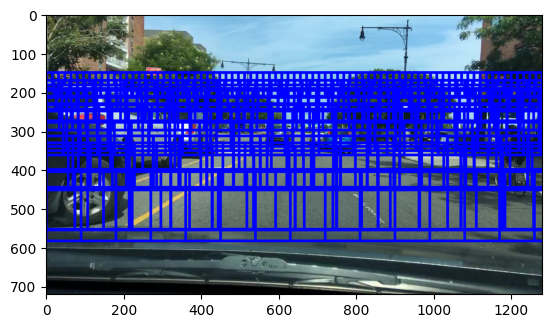

In [28]:
def slide_window(img, x_start_stop=[None, None], y_start_stop=[None, None]):
    windows_a = slide_window_helper(img, x_start_stop, y_start_stop, window_size=[128, 128])
    windows_b = slide_window_helper(img, x_start_stop, y_start_stop, window_size=[64, 64])
    windows_c = slide_window_helper(img, x_start_stop, y_start_stop, window_size=[32, 32])
    return windows_a + windows_b + windows_c

# Define a function that takes an image,
# start and stop positions in both x and y, 
# window size (x and y dimensions),  
# and overlap fraction (for both x and y)
def slide_window_helper(img, x_start_stop=[None, None], y_start_stop=[None, None], window_size=[96, 64]):
    window_size_x = window_size[0]
    window_size_y = window_size[1]
    xy_overlap=(0.5, 0.5)
    # If x and/or y start/stop positions not defined, set to image size
    if x_start_stop[0] == None:
        x_start_stop[0] = 0
    if x_start_stop[1] == None:
        x_start_stop[1] = img.shape[1]
    if y_start_stop[0] == None:
        y_start_stop[0] = 0
    if y_start_stop[1] == None:
        y_start_stop[1] = img.shape[0]
    # Compute the span of the region to be searched    
    xspan = x_start_stop[1] - x_start_stop[0]
    yspan = y_start_stop[1] - y_start_stop[0]
    # Compute the number of pixels per step in x/y
    nx_pix_per_step = np.int32(window_size_x*(1 - xy_overlap[0]))
    ny_pix_per_step = np.int32(window_size_y*(1 - xy_overlap[1]))
    # Compute the number of windows in x/y
    nx_windows = np.int32(xspan/nx_pix_per_step) - 2
    ny_windows = np.int32(yspan/ny_pix_per_step) - 2
    # Initialize a list to append window positions to
    window_list = []
    
    ys = y_start_stop[0]
    while ys + window_size_y < y_start_stop[1]: 
        xs = x_start_stop[0]
        while xs < x_start_stop[1]:
            # Calculate window position
            endx = xs + window_size_x
            endy = ys + window_size_y

            # Append window position to list
            window_list.append(((xs, ys), (endx, endy)))

            xs += nx_pix_per_step
        window_size_x = int(window_size_x * 1.3)
        window_size_y = int(window_size_y * 1.3)
        nx_pix_per_step = np.int32(window_size_x*(1 - xy_overlap[0]))
        ny_pix_per_step = np.int32(window_size_y*(1 - xy_overlap[1]))
        ys += ny_pix_per_step

    # Return the list of windows
    return window_list

# Define a function to draw bounding boxes
def draw_boxes(img, bboxes, color=(0, 0, 255), thick=6):
    # Make a copy of the image
    imcopy = np.copy(img)
    # Iterate through the bounding boxes
    for bbox in bboxes:
        # Draw a rectangle given bbox coordinates
        cv2.rectangle(imcopy, bbox[0], bbox[1], color, thick)
    # Return the image copy with boxes drawn
    return imcopy

feature_image = cv2.imread('../data/train/A_001.jpg')
feature_image = cv2.cvtColor(feature_image, cv2.COLOR_BGR2RGB)
windows = slide_window(feature_image, x_start_stop=[None, None], y_start_stop=y_start_stop)              
window_img = draw_boxes(feature_image, windows, color=(0, 0, 255), thick=6)  
plt.imshow(window_img)
plt.show()

## Search Windows for Features

In [29]:
# Define a function you will pass an image 
# and the list of windows to be searched (output of slide_windows())
def search_windows(img, windows, clf, scaler, color_space='RGB', 
                    spatial_size=(32, 32), hist_bins=32, 
                    hist_range=(0, 256), orient=9, 
                    pix_per_cell=8, cell_per_block=2, 
                    hog_channel=0, spatial_feat=True, 
                    hist_feat=True, hog_feat=True):

    # Create an empty list to receive positive detection windows
    on_windows = []
    # Iterate over all windows in the list
    count = 0
    image_id = random.randint(0, 2000)
    for window in windows:
        count += 1
        # Extract the test window from original image
        test_img = cv2.resize(img[window[0][1]:window[1][1], window[0][0]:window[1][0]], (64, 64))
#         cv2.imwrite("frames/window%d%d.jpg" % (image_id, count), test_img)
        # Extract features for that window using single_img_features()
        features = single_img_features(test_img, color_space=color_space, 
                            spatial_size=spatial_size, hist_bins=hist_bins, 
                            orient=orient, pix_per_cell=pix_per_cell, 
                            cell_per_block=cell_per_block, 
                            hog_channel=hog_channel, spatial_feat=spatial_feat, 
                            hist_feat=hist_feat, hog_feat=hog_feat)
        # Scale extracted features to be fed to classifier
        test_features = scaler.transform(np.array(features).reshape(1, -1))
        # Predict using your classifier
        prediction = clf.predict(test_features)
        # If positive (prediction == 1) then save the window
        if prediction == 1:
            on_windows.append(window)
    # Return windows for positive detections
    return on_windows

## Pipeline: Search Image and Label Vehicles

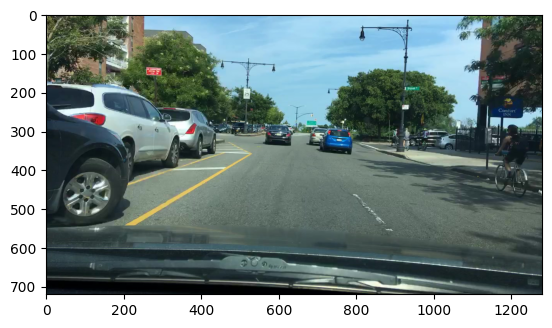

In [43]:
# plt.imshow('../data/train/A_00'+str(1)+'.jpg')

from skimage import io
io.imread('../data/train/A_001.jpg')
plt.imshow(io.imread('../data/train/A_001.jpg'))

0
1
2
3
4


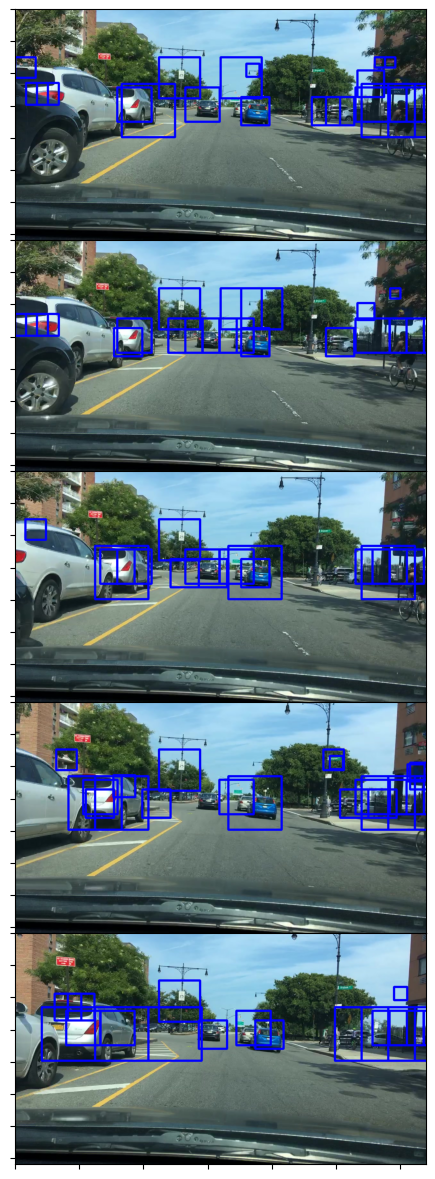

In [46]:
def label_vehicles(image, X_scaler):
    draw_image = np.copy(image)
    draw_image = cv2.cvtColor(draw_image, cv2.COLOR_RGB2BGR)
    windows = slide_window(image, x_start_stop=[None, None], y_start_stop=y_start_stop)
    hot_windows = search_windows(image, windows, svc, X_scaler, color_space=color_space, 
                            spatial_size=spatial_size, hist_bins=hist_bins, 
                            orient=orient, pix_per_cell=pix_per_cell, 
                            cell_per_block=cell_per_block, 
                            hog_channel=hog_channel, spatial_feat=spatial_feat, 
                            hist_feat=hist_feat, hog_feat=hog_feat)                       

    window_img = draw_boxes(draw_image, hot_windows, color=(0, 0, 255), thick=6)  
    return window_img

f, axarr = plt.subplots(5, 1, figsize=(30, 15))
startIndex = random.randint(1, 1250)
for i in range(0,5):
    print(i)
    index = i + startIndex
    img = cv2.imread('../data/train/A_00'+str(i+1)+'.jpg')
    img_with_label = label_vehicles(img, X_scaler)
    axarr[i].imshow(img_with_label)
plt.setp([a.get_xticklabels() for a in axarr[:]], visible=False)
plt.setp([a.get_yticklabels() for a in axarr[:]], visible=False)
f.subplots_adjust(hspace=0)
plt.show()

## Use Heat Map to Reduce False Positives and Dupes

C:\Users\alexa\AppData\Local\Temp\ipykernel_24936\2947315112.py:1: DeprecationWarning: Please use `label` from the `scipy.ndimage` namespace, the `scipy.ndimage.measurements` namespace is deprecated.
  from scipy.ndimage.measurements import label


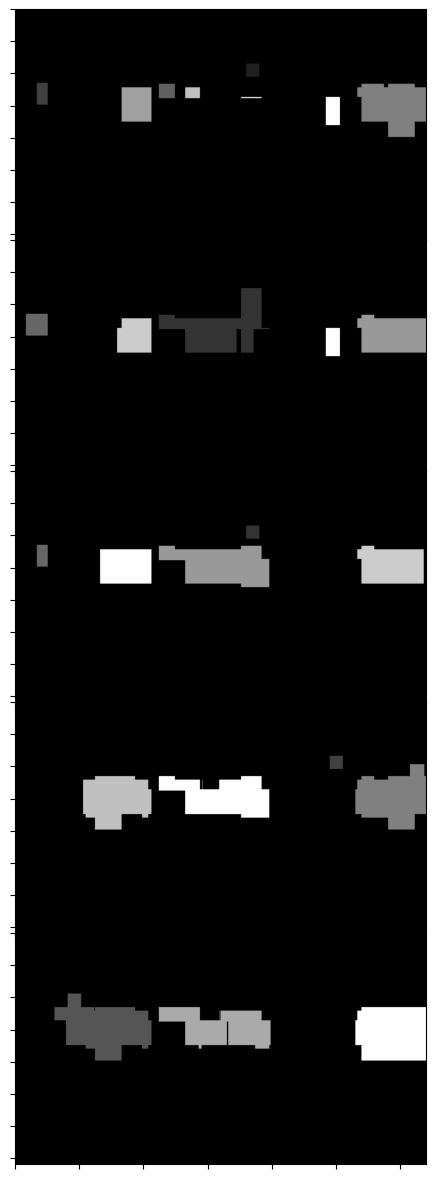

In [48]:
from scipy.ndimage.measurements import label
def add_heat(heatmap, bbox_list):
    heatmap /= 2
    # Iterate through list of bboxes
    for box in bbox_list:
        # Add += 1 for all pixels inside each bbox
        # Assuming each "box" takes the form ((x1, y1), (x2, y2))
        heatmap[box[0][1]:box[1][1], box[0][0]:box[1][0]] += 2

    # Return updated heatmap
    return heatmap

def apply_threshold(heatmap, threshold):
    # Zero out pixels below the threshold
    heatmap[heatmap <= threshold] = 0
    # Return thresholded map
    return heatmap

image = cv2.imread('../data/train/A_001.jpg')
heatmap = np.zeros_like(image[:,:,0]).astype(np.float32)
f, axarr = plt.subplots(5, 1, figsize=(30, 15))
labels_list = []
startIndex = random.randint(1, 1250)
for i in range(0,5):
    index = i + startIndex
    image = cv2.imread('../data/train/A_00'+str(i+1)+'.jpg')
    windows = slide_window(image, x_start_stop=[None, None], y_start_stop=y_start_stop)
    hot_windows = search_windows(image, windows, svc, X_scaler, color_space=color_space, 
                            spatial_size=spatial_size, hist_bins=hist_bins, 
                            orient=orient, pix_per_cell=pix_per_cell, 
                            cell_per_block=cell_per_block, 
                            hog_channel=hog_channel, spatial_feat=spatial_feat, 
                            hist_feat=hist_feat, hog_feat=hog_feat)
    heatmap = add_heat(heatmap, hot_windows)
    heatmap = apply_threshold(heatmap, 2)
    labels = label(heatmap)
    labels_list.append(labels)
    axarr[i].imshow(labels[0], 'gray')
plt.setp([a.get_xticklabels() for a in axarr[:]], visible=False)
plt.setp([a.get_yticklabels() for a in axarr[:]], visible=False)
f.subplots_adjust(hspace=0)
plt.show()

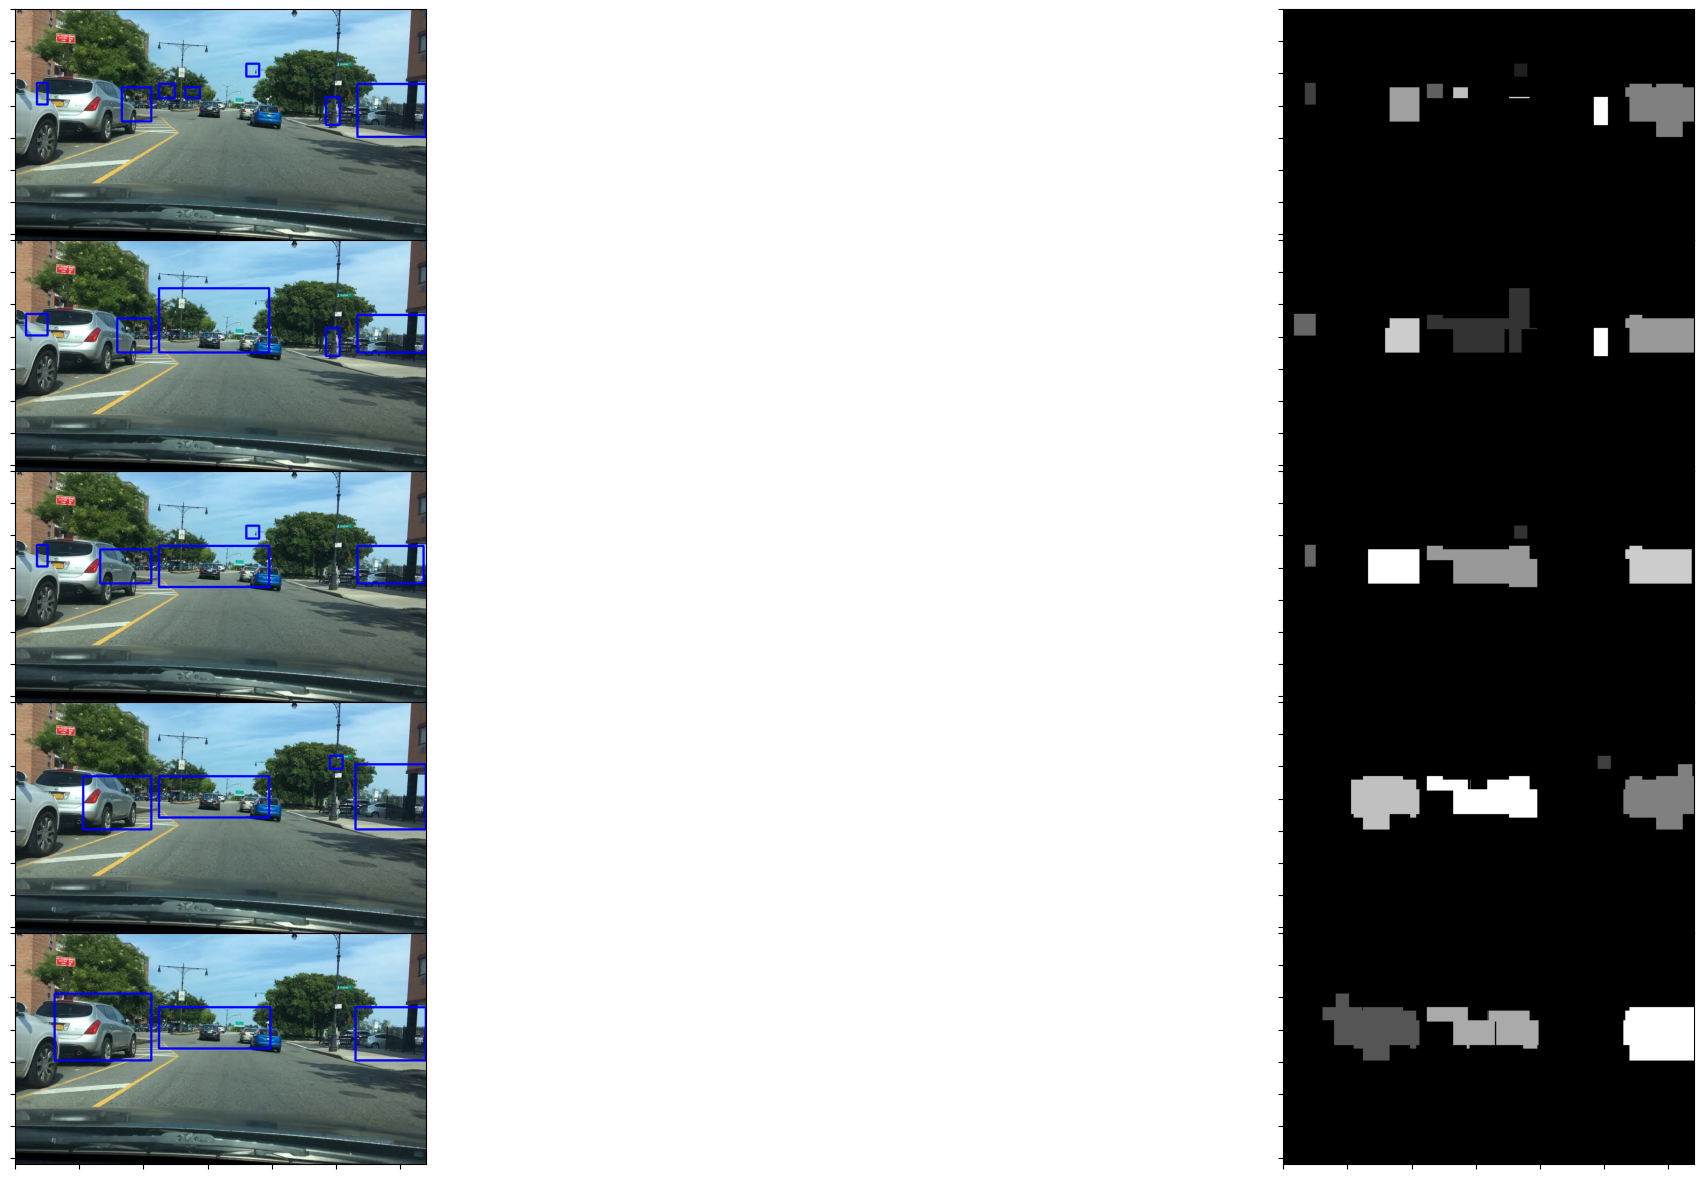

In [49]:
def draw_labeled_bboxes(img, labels):
    # Iterate through all detected cars
    for car_number in range(1, labels[1]+1):
        # Find pixels with each car_number label value
        nonzero = (labels[0] == car_number).nonzero()
        # Identify x and y values of those pixels
        nonzeroy = np.array(nonzero[0])
        nonzerox = np.array(nonzero[1])
        # Define a bounding box based on min/max x and y
        bbox = ((np.min(nonzerox), np.min(nonzeroy)), (np.max(nonzerox), np.max(nonzeroy)))
        # Draw the box on the image if it's big enough
        if((bbox[1][1] - bbox[0][1]) > 30 and (bbox[1][0] - bbox[0][0]) > 30):
            cv2.rectangle(img, bbox[0], bbox[1], (0,0,255), 6)
    # Return the image
    return img

# Draw bounding boxes on a copy of the image
f, axarr = plt.subplots(5, 2, figsize=(30, 15))
for i in range(len(labels_list)):
    labels = labels_list[i]
    draw_image = np.copy(image)
    draw_image = cv2.cvtColor(draw_image, cv2.COLOR_RGB2BGR)
    draw_img = draw_labeled_bboxes(draw_image, labels)
    axarr[i, 1].imshow(labels[0], 'gray')
    axarr[i, 0].imshow(draw_img, 'gray')

plt.setp([a.get_xticklabels() for a in axarr[:, 0]], visible=False)
plt.setp([a.get_yticklabels() for a in axarr[:, 0]], visible=False)
plt.setp([a.get_xticklabels() for a in axarr[:, 1]], visible=False)
plt.setp([a.get_yticklabels() for a in axarr[:, 1]], visible=False)
f.subplots_adjust(hspace=0)
plt.show()

## Pipeline: Add Heatmap Filtering

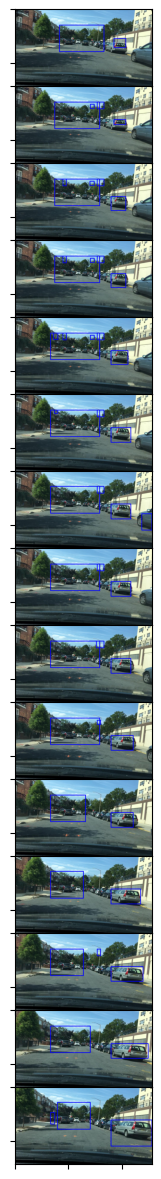

In [69]:
def label_vehicles_with_heat_map(image, convert=True, return_windows=False):
    draw_image = np.copy(image)
    if(convert):
        image = cv2.cvtColor(image, cv2.COLOR_RGB2BGR)
    else:
        draw_image = cv2.cvtColor(draw_image, cv2.COLOR_BGR2RGB)
    windows = slide_window(image, x_start_stop=[None, None], y_start_stop=y_start_stop)

    hot_windows = search_windows(image, windows, svc, X_scaler, color_space=color_space, 
                            spatial_size=spatial_size, hist_bins=hist_bins, 
                            orient=orient, pix_per_cell=pix_per_cell, 
                            cell_per_block=cell_per_block, 
                            hog_channel=hog_channel, spatial_feat=spatial_feat, 
                            hist_feat=hist_feat, hog_feat=hog_feat)
    global heatmap
    heatmap = add_heat(heatmap, hot_windows)
    heatmap = apply_threshold(heatmap, 2)
    labels = label(heatmap)
    
    # Draw bounding boxes on a copy of the image
    draw_img = draw_labeled_bboxes(draw_image, labels)

    if return_windows:
        return draw_img, hot_windows
    else:
        return draw_img

heatmap = np.zeros_like(image[:,:,0]).astype(np.float32)

f, axarr = plt.subplots(15, 1, figsize=(30, 15))
startIndex = random.randint(100, 180)
for i in range(0,15):
    index = i + startIndex
    img = cv2.imread('../data/train/A_'+str(index)+'.jpg')
    
    window_img = label_vehicles_with_heat_map(img, convert=False)
    axarr[i].imshow(window_img)
plt.setp([a.get_xticklabels() for a in axarr[:]], visible=False)
plt.setp([a.get_yticklabels() for a in axarr[:]], visible=False)
f.subplots_adjust(hspace=0)
plt.show()

In [86]:
heatmap = np.zeros_like(image[:,:,0]).astype(np.float32)
img = cv2.imread('../data/test/193.jpg')
window_img, windows = label_vehicles_with_heat_map(img, convert=False, return_windows=True)
windows = [list(t1) + list(t2) for t1, t2 in windows]
windows


[]

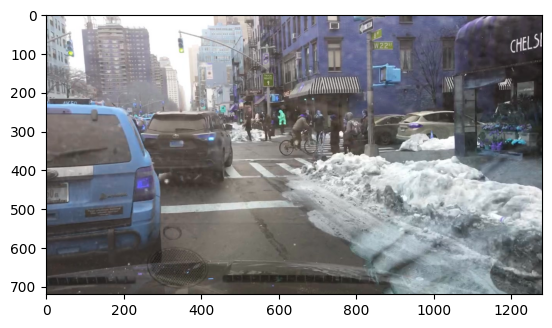

In [87]:
plt.imshow(img)

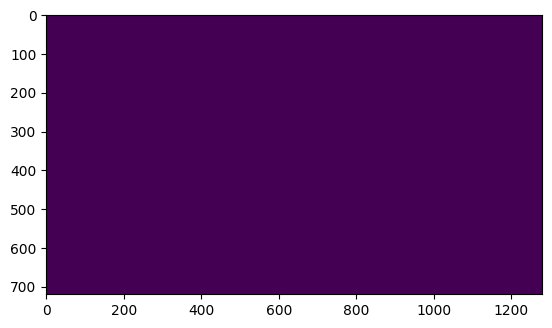

In [88]:
def bounding_boxes_to_mask(bounding_boxes, H, W):
    
    """
    Converts set of bounding boxes to a binary mask
    """

    mask = np.zeros((H, W))
    for x, y, dx, dy in bounding_boxes:
        mask[y:y+dy, x:x+dx] = 1

    return mask

plt.imshow(bounding_boxes_to_mask(windows, 720, 1280))

In [80]:
import os

test_dir = os.path.join('../data', 'test')
test_files = sorted(os.listdir(test_dir), key=lambda x: int(x.split('.')[0]))

In [81]:
def bounding_boxes_to_mask(bounding_boxes, H, W):
    
    """
    Converts set of bounding boxes to a binary mask
    """

    mask = np.zeros((H, W))
    for x, y, dx, dy in bounding_boxes:
        mask[y:y+dy, x:x+dx] = 1

    return mask

def run_length_encoding(mask):

    """
    Produces run length encoding for a given binary mask
    """
    
    # find mask non-zeros in flattened representation
    non_zeros = np.nonzero(mask.flatten())[0]
    padded = np.pad(non_zeros, pad_width=1, mode='edge')
    
    # find start and end points of non-zeros runs
    limits = (padded[1:] - padded[:-1]) != 1
    starts = non_zeros[limits[:-1]]
    ends = non_zeros[limits[1:]]
    lengths = ends - starts + 1

    return ' '.join(['%d %d' % (s, l) for s, l in zip(starts, lengths)])


heatmap = np.zeros_like(image[:,:,0]).astype(np.float32)

rows=[]
       
for file_name in tqdm(test_files):

    test_image = cv2.imread('../data/test/' + file_name)

    window_img, windows = label_vehicles_with_heat_map(test_image, convert=False, return_windows=True)
    windows = [list(t1) + list(t2) for t1, t2 in windows]
  
    # encode the bounding boxes detected for the frame
    rle = run_length_encoding(bounding_boxes_to_mask(windows, 720, 1280))

    #append the predicted bounding boxes to your results' list
    rows.append(['test/' + file_name, rle])

# generate csv submission
import pandas as pd
df_prediction = pd.DataFrame(columns=['Id', 'Predicted'], data=rows).set_index('Id')
df_prediction.to_csv('outputs/vehicledetection.csv')

 95%|█████████▌| 192/202 [08:07<00:25,  2.54s/it]


ValueError: can't extend empty axis 0 using modes other than 'constant' or 'empty'

## Discussion

#### 1. Briefly discuss any problems / issues you faced in your implementation of this project. Where will your pipeline likely fail? What could you do to make it more robust?

One of the key limitations to my project currently is how long the pipeline takes to process a video stream. An obvious improvement would be to precompute HOG values for the image before splitting into the windows. After spending a few days working on that issue, I decided to delay it until a later iteration of the project. In its current state, the pipeline would not be useful for doing on-the-fly obstacle identification.

Another limitation is that it often fails to identify cars that are far away. In order to improve the long range accuracy of the project, I could create a more dynamic window scaling tool that samples only from areas within the road.

Finally, I would still like to get tighter bounding boxes on the vehicles themselves. This could be solved by acquiring a training image set with more partial vehicle images so that I could use smaller windows. 